In [1]:
import os
import pickle
from collections import defaultdict
from itertools import product
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def parse_results(directory, length_param_grid):
    
    files = [x for x in os.listdir(directory) if 'results' in x and '.txt.txt' not in x]

    results_dict = defaultdict(lambda:0)
    number_runs = defaultdict(lambda:0)
    all_params = []

    for file in files:
        param = int(file.split('_')[-2][1:])
        run_number = int(file.split('_')[-1].split('.')[0][1:])

        with open(directory+file, 'rb') as f:
            result = pickle.load(f)

        results_dict[param] += sum(result['presence_VR'])
        number_runs[param] += 10

        all_params.append((param, run_number))

    results_dict = dict(results_dict)
    
    # check that all runs are present
    missing = set(product(range(length_param_grid), range(100))).symmetric_difference(set(all_params))
    if len(missing) == 0:
        print('All runs have been parsed')
    else:
        print('Some runs are missing:', missing)
    
    percentage_takeover = dict(zip(list(results_dict.keys()), [results_dict[p]/number_runs[p] for p in list(results_dict.keys())]))
    confidence_intervals =  dict(zip(list(results_dict.keys()),[1.96*np.sqrt((percentage_takeover[p]*(1-percentage_takeover[p]))/1000) for p in list(results_dict.keys())]))
    
    return(percentage_takeover, confidence_intervals)

In [3]:
basic_results, basic_ci = parse_results('bar_chart/basic_model/', 72)
immunitywaning_nobooster_results, immunitywaning_nobooster_ci = parse_results('bar_chart/immunity_waning_no_booster/', 72)
immunitywaning_booster_results, immunitywaning_booster_ci = parse_results('bar_chart/immunity_waning_booster/', 72)

All runs have been parsed
All runs have been parsed
All runs have been parsed


In [4]:
paramgrid_basic_file = 'bar_chart/basic_model/paramgrid_appearance_barchart_basic.txt'
with open(paramgrid_basic_file, 'rb') as f:
    paramgrid_basic = pickle.load(f)
df_basic = pd.DataFrame(paramgrid_basic)

paramgrid_immunity_file = 'bar_chart/immunity_waning_booster/paramgrid_appearance_barchart_immunitywaning.txt'
with open(paramgrid_immunity_file, 'rb') as f:
    paramgrid_immunity = pickle.load(f)
df_immunity = pd.DataFrame(paramgrid_immunity)

In [5]:
def get_index(df, desired_dict):

    subdf = df.copy()

    for keyval in desired_dict:
        subdf = subdf[subdf[keyval] == desired_dict[keyval]]
        
    # check that index unique
    if len(list(subdf.index)) != 1:
        print('Index not unique')
        
    return(subdf.index[0])

In [29]:
desired_dict =  {'delta':1, 'mu':1e-6, 'q':0.4, 'c':1000, 'i_threshold':500}

In [30]:
results_basic = []
results_no_booster = []
results_booster = []

ci_basic = []
ci_no_booster = []
ci_booster = []

combs_cl = [(100,1000),(100,10000),(500,1000),(500,10000)]

for L,c in combs_cl:
    
    desired_dict['c'] = c
    desired_dict['i_threshold'] = L
    
    results_basic.append(basic_results[get_index(df_basic, desired_dict)])
    results_no_booster.append(immunitywaning_nobooster_results[get_index(df_immunity, desired_dict)])
    results_booster.append(immunitywaning_booster_results[get_index(df_immunity, desired_dict)])
    
    ci_basic.append(basic_ci[get_index(df_basic, desired_dict)])
    ci_no_booster.append(immunitywaning_nobooster_ci[get_index(df_immunity, desired_dict)])
    ci_booster.append(immunitywaning_booster_ci[get_index(df_immunity, desired_dict)])

In [31]:
results_no_booster = np.array(results_no_booster)
results_booster = np.array(results_booster)
results_basic =  np.array(results_basic)

In [32]:
ci_booster

[0.006464732508000621,
 0.0033897235285491943,
 0.014487569071448806,
 0.010046027752300906]

In [44]:
def immunity(t, N, mu, L, c, h):
    p1 = (c*L*mu*(1-np.exp(-h*t)))/(h**2)
    p2 = -(c*L*mu*t)/h
    p3 = -(L*L*mu*t*t)/2
    
    print(p1,p2,p3)
    
    return(np.exp(p1+p2+p3))

In [45]:
L = 500
c = 10000
mu = 1e-7
N = 1e6
TH = N*(2/3)/(L+c)
print(TH)
print(1-immunity(TH, N, mu, L, c, 180))

63.49206349206349
1.54320987654321e-05 -0.1763668430335097 -50.39052658100276
1.0


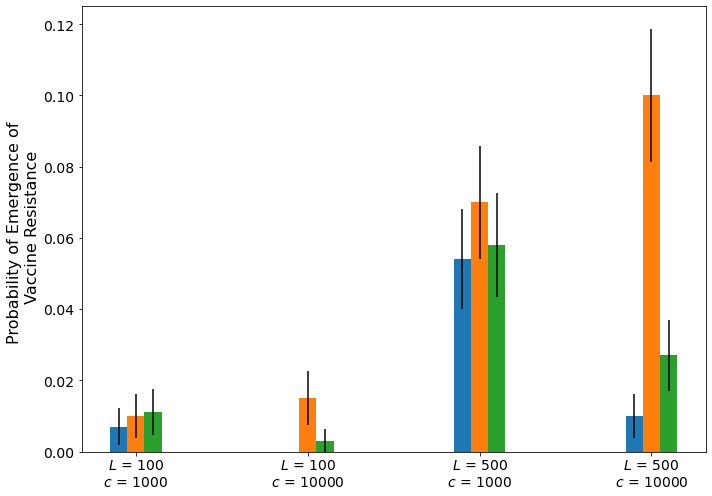

In [36]:
x = np.arange(0,4.,1)  # the label locations
width = 0.1  # the width of the bars

fig, ax = plt.subplots(figsize = (10,7))

bars_basic = ax.bar(x - width, results_basic, width, yerr = ci_basic, label='Basic Model')
bars_nobooster = ax.bar(x, results_no_booster, width, yerr = ci_no_booster, label='Immunity Waning, No Booster')
bars_booster = ax.bar(x + width, results_booster, width,  yerr = ci_booster, label='Immunity Waning, Boosters')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Probability of Emergence of \n Vaccine Resistance', fontsize = 16)
#ax.set_title('Scores by group and gender')
ax.set_xticks(x)
ax.set_xticklabels(['$L$ = ' + str(x[0]) + '\n$c$ = ' + str(x[1])  for x in combs_cl], fontsize = 14)
#ax.legend(fontsize = 14)
ax.set_ylim(0.,0.125)
ax.tick_params(labelsize = '14')
#ax.bar_label(bars_age_structure_0, padding=3)
#ax.bar_label(bars_age_structure_1, padding=3)

fig.tight_layout()
plt.savefig('immunity_waning_mu6_q04_delta1.jpg', dpi = 400)
plt.show()

In [87]:
results_basic

array([0., 0., 0., 0.])